# AIzynthFinder

In [12]:

import glob
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from aizynthfinder.interfaces import aizynthcli
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, RDConfig
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import MDS

sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

In [132]:
#Converting the genereted aurora Kinase B inhibtors to SMILES 


def convert_directory_sdf_to_dataframe(input_dir: str) -> pd.DataFrame:
    """
    Reads all `.sdf` files in `input_dir` and returns a DataFrame with columns:
      - name: molecule name (from filename or `_Name` property)
      - smiles: isomeric SMILES string
    """
    records = []
    sdf_paths = glob.glob(os.path.join(input_dir, '*.sdf'))
    if not sdf_paths:
        raise FileNotFoundError(f"No .sdf files found in {input_dir}")

    for sdf_path in sdf_paths:
        suppl = Chem.SDMolSupplier(sdf_path, sanitize=True, removeHs=False)
        base_name = os.path.splitext(os.path.basename(sdf_path))[0]
        for mol in suppl:
            if mol is None:
                continue
            name =  base_name
            smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
            records.append({'name': name, 'smiles': smiles})

    return pd.DataFrame(records)

input_dir = './sdf'

df = convert_directory_sdf_to_dataframe(input_dir)

df.to_csv("./graph.csv")


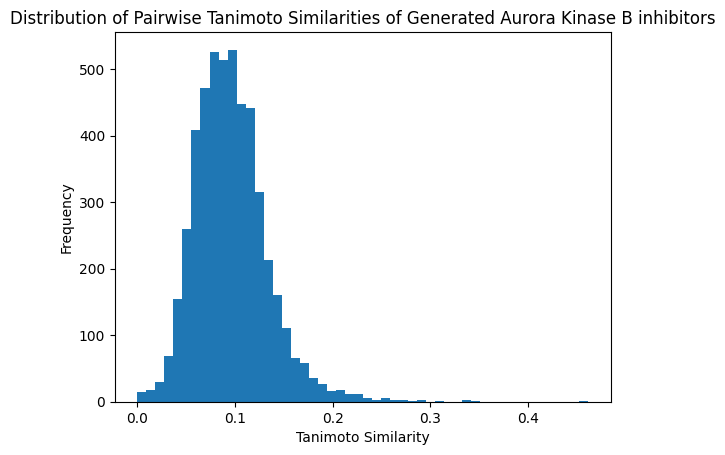

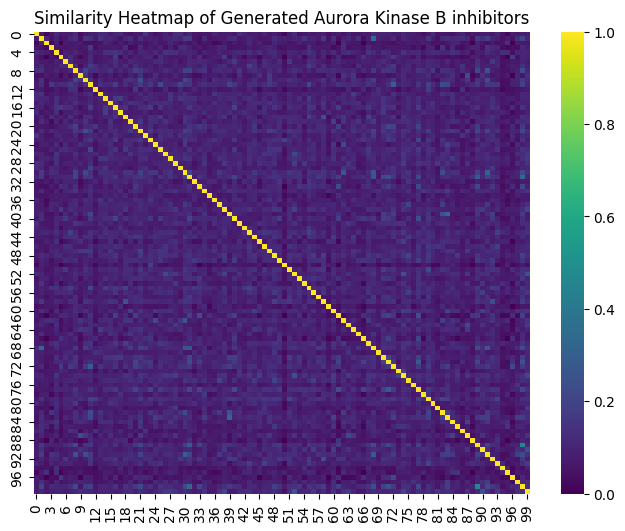

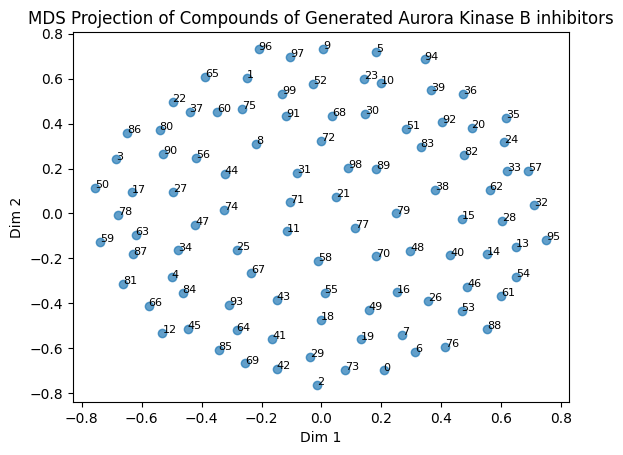

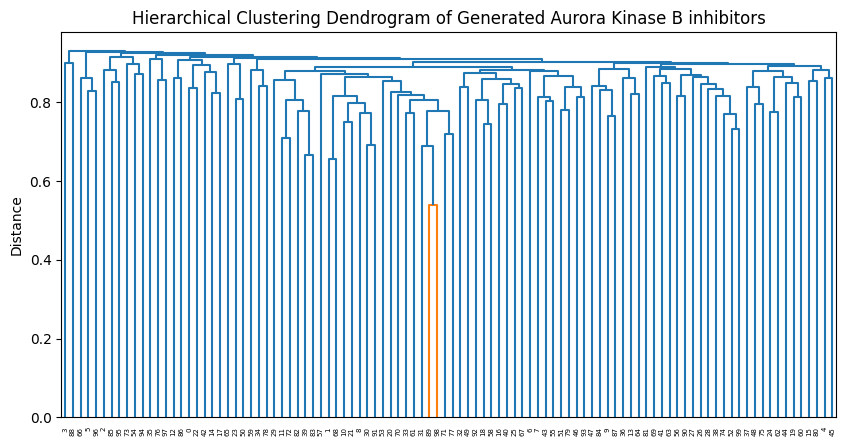

In [133]:


# Function to compute Morgan fingerprints for a list of SMILES

def compute_fingerprints(smiles_list, radius=2, nBits=2048):
    fps = []
    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
            fps.append(fp)
        else:
            fps.append(None)
    return fps

# Compute full pairwise Tanimoto similarity matrix

def compute_similarity_matrix(fps):
    n = len(fps)
    sim_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if fps[i] and fps[j]:
                sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
            else:
                sim = np.nan
            sim_mat[i, j] = sim
            sim_mat[j, i] = sim
    return sim_mat

# Plot histogram of all pairwise similarities

def plot_similarity_hist(sim_mat,plot_name,  bins=50):
    sims = sim_mat[np.triu_indices_from(sim_mat, k=1)]
    sims = sims[~np.isnan(sims)]
    plt.figure()
    plt.hist(sims, bins=bins)
    plt.xlabel('Tanimoto Similarity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Pairwise Tanimoto Similarities of ' + plot_name)
    plt.show()

# Plot a heatmap of the similarity matrix (subset for readability)

def plot_heatmap(sim_mat, plot_name, labels=None, max_items=100):
    n = sim_mat.shape[0]
    idx = np.arange(min(n, max_items))
    sub_mat = sim_mat[np.ix_(idx, idx)]
    plt.figure(figsize=(8,6))
    sns.heatmap(sub_mat,  cmap='viridis')
    plt.title('Similarity Heatmap of ' + plot_name)
    plt.show()

# MDS projection of compounds based on similarity

def plot_mds(sim_mat, plot_name, labels=None):
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    dist = 1 - sim_mat
    coords = mds.fit_transform(dist)
    plt.figure()
    plt.scatter(coords[:,0], coords[:,1], alpha=0.7)
    if labels:
        for i, txt in enumerate(labels):
            plt.annotate(txt, (coords[i,0], coords[i,1]), fontsize=8)
    plt.title('MDS Projection of Compounds of ' + plot_name)
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.show()

# Hierarchical clustering and dendrogram

def plot_dendrogram(sim_mat, plot_name, labels=None):
    dist = 1 - sim_mat
    from scipy.spatial.distance import squareform
    condensed = squareform(dist, checks=False)
    Z = linkage(condensed, method='average')
    plt.figure(figsize=(10, 5))
    dendrogram(Z, leaf_rotation=90)
    plt.title('Hierarchical Clustering Dendrogram of ' + plot_name)
    plt.ylabel('Distance')
    plt.savefig("ff.png")
    plt.show()
    

# Main routine: loads DataFrame and runs analyses

def main(df, plot_name):
    smiles = df['smiles'].tolist()
    labels = df.index.astype(str).tolist()
    fps = compute_fingerprints(smiles)
    sim_mat = compute_similarity_matrix(fps)
    plot_similarity_hist(sim_mat, plot_name)
    plot_heatmap(sim_mat, plot_name, labels)
    plot_mds(sim_mat,  plot_name, labels)
    plot_dendrogram(sim_mat,  plot_name, labels)

main(df, "Generated Aurora Kinase B inhibitors")

# Analysis for Generated Aurora Kinase B inhibitors 


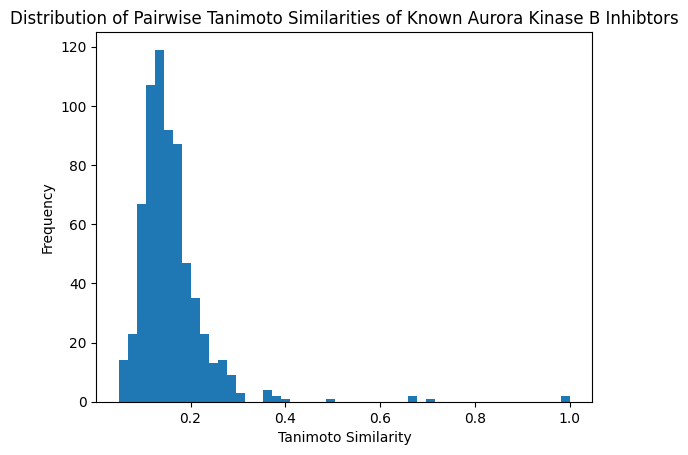

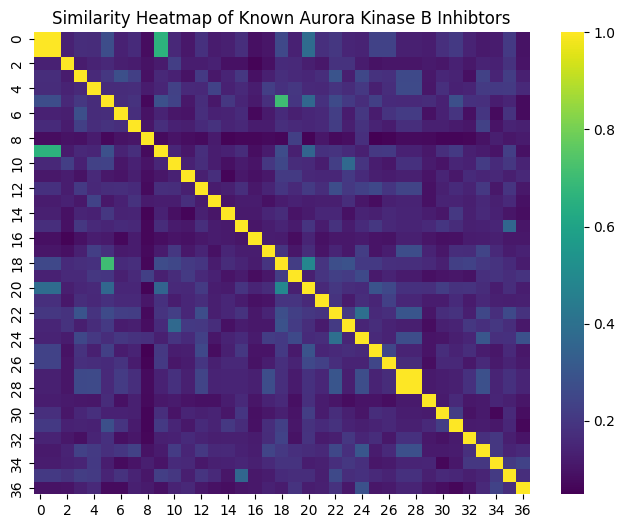

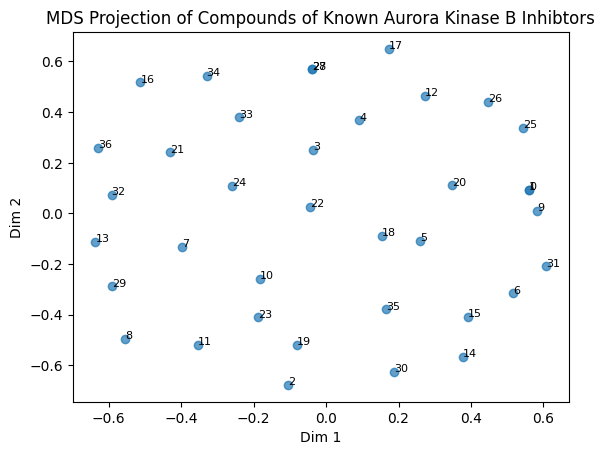

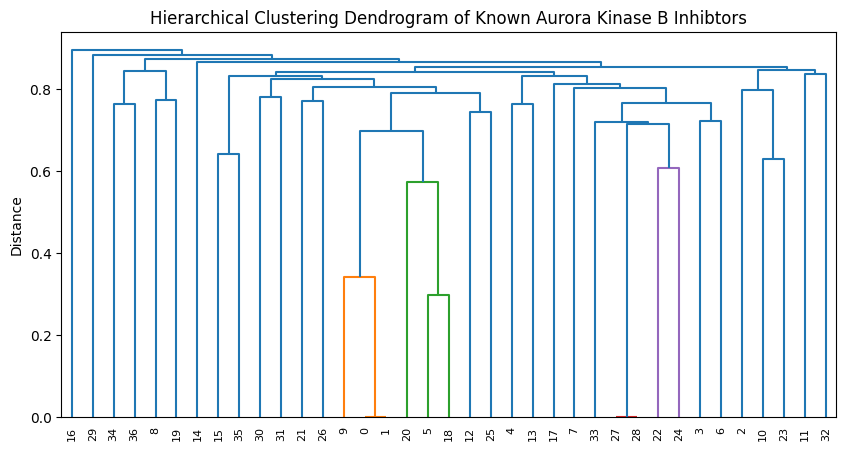

In [57]:
df2 = pd.read_csv('./aurora kinase B interactions.csv', index_col=False)
main(df2, "Known Aurora Kinase B Inhibtors")

# analysis for Known Aurora Kinase B from https://www.guidetopharmacology.org/GRAC/ObjectDisplayForward?objectId=1937

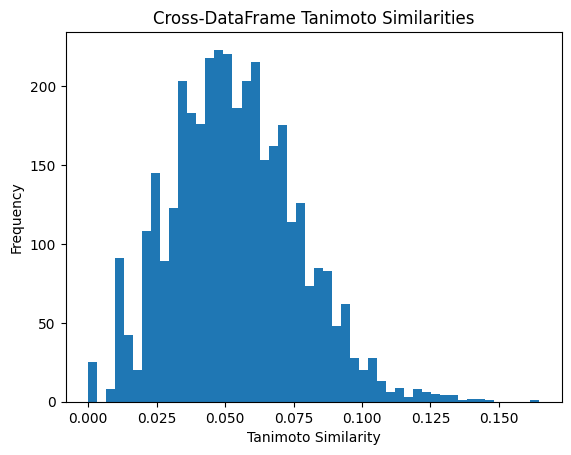

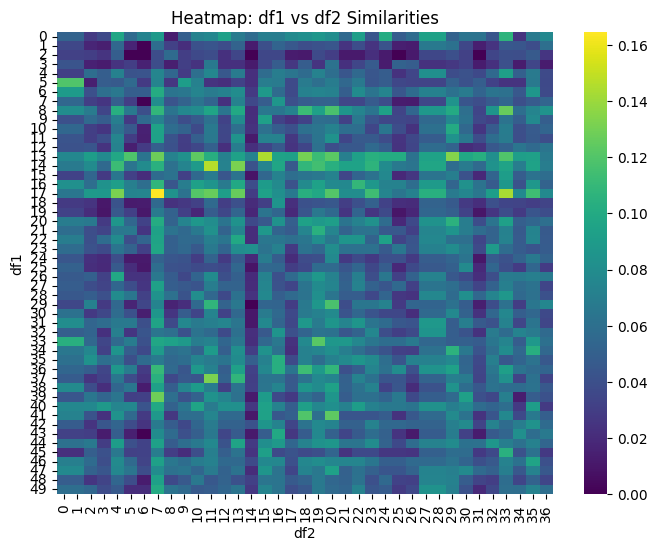

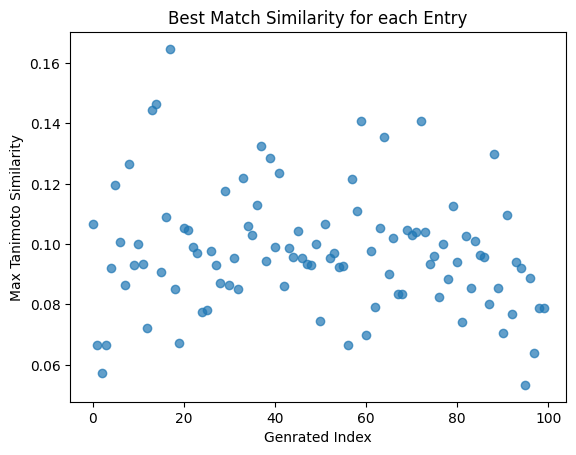

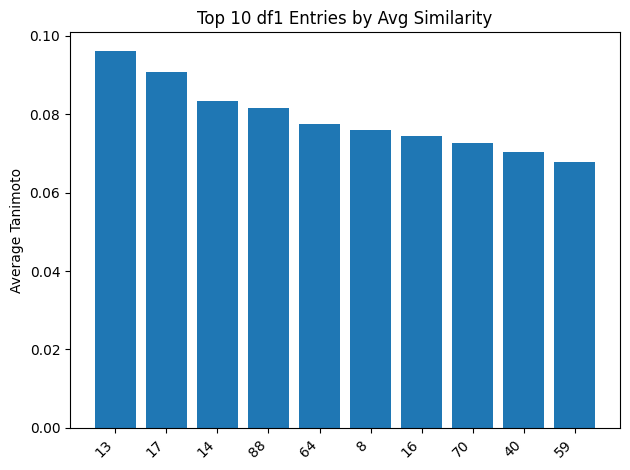

In [135]:

# Compute Morgan fingerprints

def compute_fingerprints(smiles_list, radius=2, nBits=2048):
    fps = []
    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        fps.append(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits) if mol else None)
    return fps

# Compute pairwise Tanimoto between two sets of fingerprints

def compute_cross_similarity_matrix(fps1, fps2):
    n1, n2 = len(fps1), len(fps2)
    sim_mat = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            if fps1[i] and fps2[j]:
                sim_mat[i, j] = DataStructs.TanimotoSimilarity(fps1[i], fps2[j])
            else:
                sim_mat[i, j] = np.nan
    return sim_mat

# Plot histogram of cross-set similarities

def plot_cross_hist(sim_mat, bins=50):
    sims = sim_mat.flatten()
    sims = sims[~np.isnan(sims)]
    plt.figure()
    plt.hist(sims, bins=bins)
    plt.xlabel('Tanimoto Similarity')
    plt.ylabel('Frequency')
    plt.title('Cross-DataFrame Tanimoto Similarities')
    plt.show()

# Heatmap of cross similarities (subset)

def plot_cross_heatmap(sim_mat, labels1=None, labels2=None, max_items=50):
    i = np.arange(min(sim_mat.shape[0], max_items))
    j = np.arange(min(sim_mat.shape[1], max_items))
    sub = sim_mat[np.ix_(i, j)]
    plt.figure(figsize=(8,6))
    sns.heatmap(sub, xticklabels=[labels2[k] for k in j] if labels2 else j,
                yticklabels=[labels1[k] for k in i] if labels1 else i,
                cmap='viridis')
    plt.title('Heatmap: df1 vs df2 Similarities')
    plt.xlabel('df2')
    plt.ylabel('df1')
    plt.show()

# Plot best match similarity for each row in df1

def plot_best_match(sim_mat, labels1=None, labels2=None):
    best_idx = np.nanargmax(sim_mat, axis=1)
    best_sims = np.nanmax(sim_mat, axis=1)
    plt.figure()
    plt.scatter(range(len(best_sims)), best_sims, alpha=0.7)
    plt.xlabel('Genrated Index')
    plt.ylabel('Max Tanimoto Similarity')
    plt.title('Best Match Similarity for each Entry')
    plt.show()

# Bar plot of top N average similarities (df1 perspective)

def plot_top_avg_sims(sim_mat, top_n=10, labels1=None):
    avg_sims = np.nanmean(sim_mat, axis=1)
    idx = np.argsort(avg_sims)[-top_n:][::-1]
    names = [labels1[k] for k in idx] if labels1 else idx
    plt.figure()
    plt.bar(range(len(idx)), avg_sims[idx])
    plt.xticks(range(len(idx)), names, rotation=45, ha='right')
    plt.ylabel('Average Tanimoto')
    plt.title(f'Top {top_n} df1 Entries by Avg Similarity')
    plt.tight_layout()
    plt.show()

# Main analysis routine

def analyze_two_sets(df1, df2, smiles_col='smiles'):
    smiles1 = df1[smiles_col].tolist()
    smiles2 = df2[smiles_col].tolist()
    labels1 = df1.index.astype(str).tolist()
    labels2 = df2.index.astype(str).tolist()

    fps1 = compute_fingerprints(smiles1)
    fps2 = compute_fingerprints(smiles2)
    sim_mat = compute_cross_similarity_matrix(fps1, fps2)

    plot_cross_hist(sim_mat)
    plot_cross_heatmap(sim_mat, labels1, labels2)
    plot_best_match(sim_mat, labels1, labels2)
    plot_top_avg_sims(sim_mat, top_n=10, labels1=labels1)

if __name__ == '__main__':

    analyze_two_sets(df, df2)


In [138]:
def calculate_sas(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol: 
        return sascorer.calculateScore(mol)
    return None 


df2['sascore'] = df2['smiles'].apply(calculate_sas)
df['sascore'] = df['smiles'].apply(calculate_sas)

In [113]:
df.to_csv("generated_with_sa.csv")

In [118]:
df

,name,smiles,Sascore,sascore
0,17,C=C(C)NCCN1[C@H](Br)[C@H]1OO,None,4.873471
1,16,C[C@@H]1C[C@@H]1CCI,None,3.974999
2,28,S[C@@H]1NN[C@H]([SbH2])[C@H]2C[C@@H]3[C@H](C2)...,None,7.532611
3,14,OC[C@H](O)[C@@H](O)[C@@H]1O[C@@H]2[C@@H](O)[C@...,None,4.712025
4,15,CC(C)=CN[C@]12[C@H]3C[C@@H]4C[C@@]31N42,None,7.314776
...,...,...,...,...
95,31,C1[C@@H]2C[C@@H]3C[C@H]1C[C@H](C2)[C@@]12[C@H]...,None,6.986888
96,27,CCCOOC[C@H](CCC)NNC,None,3.757097
97,33,CPC[C@]12C[C@@H](CC[AsH]Br)[C@@H]1[C@@H]2CF,None,6.811925
98,32,CCCCCCCC[C@H]1C[C@H]1CC(O)O,None,3.282888


In [114]:
df2.to_csv("known_with_sa.csv")

In [139]:
df_new = pd.read_csv("known_full.csv")
df2_new = pd.read_csv("generated_full.csv")

In [125]:
df2_new["sascore"].mean()

2.88259826603083

In [141]:

print("Sascore for Known inhibtors", df_new["sascore"].mean())
print("Sascore for Generated inhibtors", df2_new["sascore"].mean())

Sascore for Known inhibtors 2.88259826603083
Sascore for Generated inhibtors 5.3572066856069736


In [142]:

print("Scscore for Known inhibtors", df_new["scscore"].mean())
print("Scscore for Generated inhibtors", df2_new["scscore"].mean())

Scscore for Known inhibtors 4.59395326635652
Scscore for Generated inhibtors 3.3566522630089053


In [128]:
df2_new["sascore"].mean()

2.88259826603083